In [1]:
import sys 
import os
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import pandas as pd
from pathlib import Path
from utils.mlflow_query import MlflowHelper
from utils.percentiles import calculate_values_per_percentiles, calculate_accuracies_per_percentiles, plot_accuracies_per_percentiles

In [3]:
mlflow_helper = MlflowHelper(pkl_file=Path("mlflow_run_df.pkl"), local_mlflow_dir_prefix='/home/ralmasri/projects/Thesis/Domain-Guided-Monitoring/mlruns/')
mlflow_helper.query_runs(pkl_file=Path("mlflow_run_df.pkl"), filter_string= "tags.test = '1'")

Initialized with 6 MLFlow runs from pkl


Querying data per run...: 100%|██████████| 6/6 [00:00<00:00, 470.51it/s]


In [4]:
percentile_names=[
    'avg_input_frequencies_percentile', 
    'median_input_frequencies_percentile', 
    'min_input_frequencies_percentile', 
    'p10_input_frequencies_percentile', 
    'unknown_inputs_percentile', 
    'output_frequency_percentile',
    'avg_input_frequencies_range', 
    'median_input_frequencies_range', 
    'min_input_frequencies_range', 
    'p10_input_frequencies_range', 
    'unknown_inputs_range', 
    "unclustered_inputs_percentile",
    "unclustered_inputs_perc_percentile",
    "clustered_inputs_percentile",
    "clustered_inputs_perc_percentile",
    "single_clustered_inputs_percentile",
    "single_clustered_inputs_perc_percentile",
    "single_clustered_inputs_clusterperc_percentile",
    "multi_clustered_inputs_percentile",
    "multi_clustered_inputs_perc_percentile",
    "multi_clustered_inputs_clusterperc_percentile",
    "avg_cluster_input_frequency_percentile",
    "median_cluster_input_frequency_percentile",
    "unclustered_inputs_range",
    "unclustered_inputs_perc_range",
    "clustered_inputs_range",
    "clustered_inputs_perc_range",
    "single_clustered_inputs_range",
    "single_clustered_inputs_perc_range",
    "single_clustered_inputs_clusterperc_range",
    "multi_clustered_inputs_range",
    "multi_clustered_inputs_perc_range",
    "multi_clustered_inputs_clusterperc_range",
    "avg_cluster_input_frequency_range",
    "median_cluster_input_frequency_range",
]

# Overall accuracy per percentiles

In [5]:
relevant_huawei_run_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False)
huawei_value_df = calculate_values_per_percentiles(
    relevant_run_df=relevant_huawei_run_df, 
    num_percentiles=10,
    percentile_names=[
        (percentile_name, percentile_name.replace("_range", "").replace("_percentile", ""))
        for percentile_name in percentile_names
        if not "output_frequency" in percentile_name
        and percentile_name.endswith("_percentile")
    ],
    cluster_threshold=0.5,
    local_mlflow_dir=mlflow_helper.local_mlflow_dir)

Calculating avg value per percentile:  17%|█▋        | 1/6 [00:06<00:30,  6.01s/it]

No attention file for run 68feef7821e74cdd99490f76c7a50a81 in local MlFlow dir
No attention file for run 68feef7821e74cdd99490f76c7a50a81 in local MlFlow dir


Calculating avg value per percentile:  50%|█████     | 3/6 [00:15<00:15,  5.15s/it]

No attention file for run 68219558fe4046de97b6dc0d1d22f8a7 in local MlFlow dir
No attention file for run 68219558fe4046de97b6dc0d1d22f8a7 in local MlFlow dir


Calculating avg value per percentile: 100%|██████████| 6/6 [00:31<00:00,  5.21s/it]


In [6]:
rel_df_huawei_1 = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, valid_x_columns=["log_cluster_template", "fine_log_cluster_template", "coarse_log_cluster_template"])
accuracy_df_1 = calculate_accuracies_per_percentiles(
   relevant_run_df=rel_df_huawei_1, k=5, num_percentiles=10, num_input_percentiles=10,
   percentile_names=percentile_names,
   local_mlflow_dir=mlflow_helper.local_mlflow_dir)
accuracy_df_1.to_csv("accuracy_df_1.csv")
accuracy_df_huawei_1 = pd.read_csv("accuracy_df_1.csv")

Calculating accuracy@k per percentile:  17%|█▋        | 1/6 [00:06<00:32,  6.55s/it]

No attention file for run 68feef7821e74cdd99490f76c7a50a81 in local MlFlow dir
No attention file for run 68feef7821e74cdd99490f76c7a50a81 in local MlFlow dir


Calculating accuracy@k per percentile:  50%|█████     | 3/6 [00:17<00:17,  5.92s/it]

No attention file for run 68219558fe4046de97b6dc0d1d22f8a7 in local MlFlow dir
No attention file for run 68219558fe4046de97b6dc0d1d22f8a7 in local MlFlow dir


Calculating accuracy@k per percentile: 100%|██████████| 6/6 [00:36<00:00,  6.01s/it]


In [7]:
relevant_huawei_run_df = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False)
huawei_accuracy_df = calculate_accuracies_per_percentiles(
    relevant_run_df=relevant_huawei_run_df, k=5, num_percentiles=10, num_input_percentiles=10,
    percentile_names=percentile_names,
    local_mlflow_dir=mlflow_helper.local_mlflow_dir)

Calculating accuracy@k per percentile:  17%|█▋        | 1/6 [00:06<00:33,  6.72s/it]

No attention file for run 68feef7821e74cdd99490f76c7a50a81 in local MlFlow dir
No attention file for run 68feef7821e74cdd99490f76c7a50a81 in local MlFlow dir


Calculating accuracy@k per percentile:  50%|█████     | 3/6 [00:18<00:17,  6.00s/it]

No attention file for run 68219558fe4046de97b6dc0d1d22f8a7 in local MlFlow dir
No attention file for run 68219558fe4046de97b6dc0d1d22f8a7 in local MlFlow dir


Calculating accuracy@k per percentile: 100%|██████████| 6/6 [00:36<00:00,  6.06s/it]


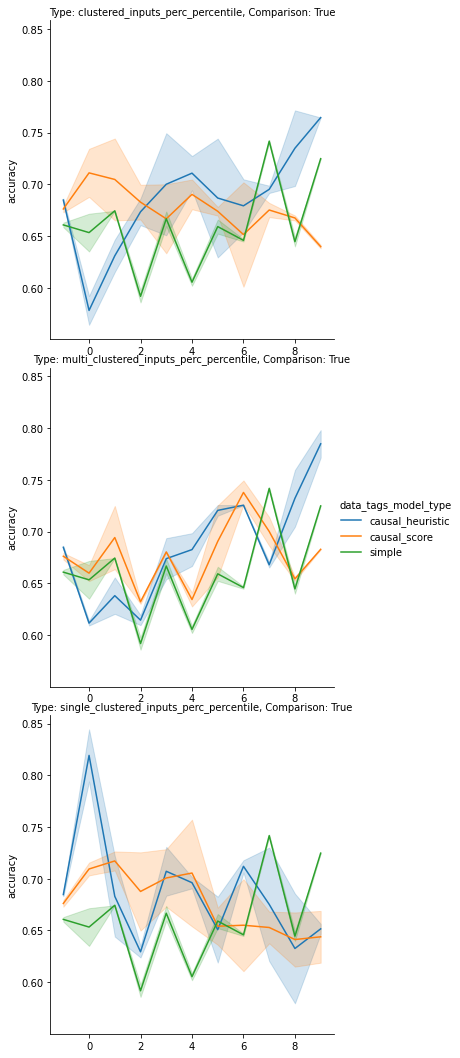

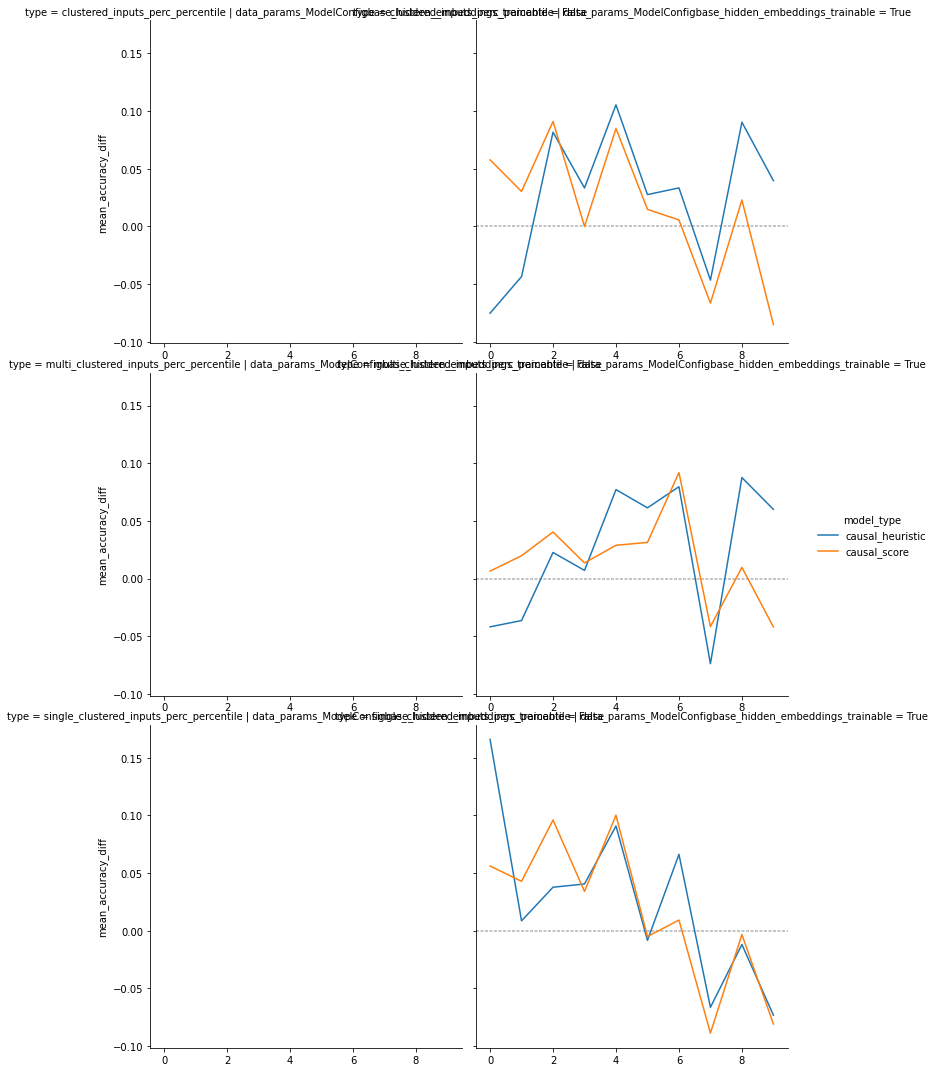

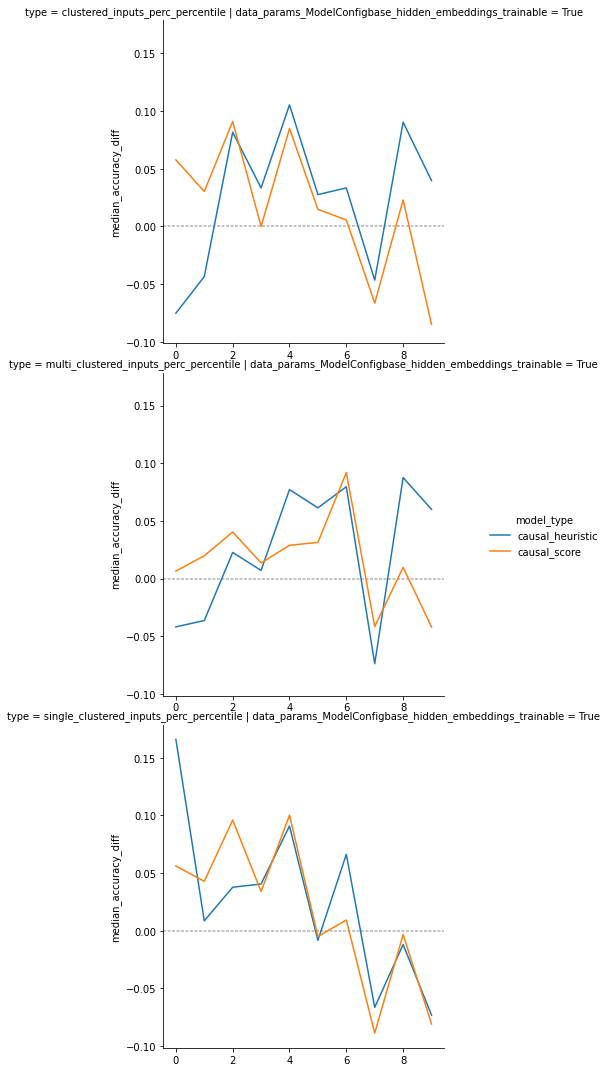

In [8]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_huawei_run_df, 
    accuracy_df=huawei_accuracy_df[
        huawei_accuracy_df["type"].apply(lambda x: x in [
            "clustered_inputs_perc_percentile",
            "single_clustered_inputs_perc_percentile",
            "multi_clustered_inputs_perc_percentile"
        ])    
    ],
    show_plot=True,
    share_y=True
)

# Accuracy@ for different input granularities

In [ ]:
merged_df = pd.merge(
    relevant_mimic_run_df2[
        relevant_mimic_run_df2["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], mimic_accuracy_df2[
        mimic_accuracy_df2["type"] == "output_frequency_percentile"
    ], left_on="info_run_id", right_on="run_id")
sns.catplot(
    data=merged_df,
    x="data_tags_model_type",
    order=["simple", "gram", "text", "causal"],
    y="accuracy",
    kind="box",
    row="percentile",
    col="data_params_SequenceConfigx_sequence_column_name",
    col_order=["level_0", "level_1", "level_2"],
    sharey="row",
).set_titles("Percentile: {row_name}, X = {col_name}").set_axis_labels(
    "", "accuracy"
)
plt.show()

In [ ]:
plot_accuracies_per_percentiles(
    relevant_run_df=relevant_mimic_run_df2[
        relevant_mimic_run_df2["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"
    ], 
    accuracy_df=mimic_accuracy_df2[
        (mimic_accuracy_df2["type"] == "output_frequency_percentile")
        & (mimic_accuracy_df2["percentile"].astype(int) > -1)
    ],
    comparison_column="data_params_SequenceConfigx_sequence_column_name",
    comparison_column_order=["level_0", "level_1", "level_2"],
    show_plot=True,
    share_y=True)

In [ ]:
grouped_df = (
    pd.merge(
        relevant_mimic_run_df2[relevant_mimic_run_df2['data_tags_model_type'] != 'causal2'], 
        mimic_accuracy_df2[mimic_accuracy_df2['type'] == 'avg_input_frequencies_percentile'], left_on="info_run_id", right_on="run_id")
    .groupby(
        [
            "data_tags_model_type",
            "data_params_ModelConfigbase_hidden_embeddings_trainable",
            "data_params_SequenceConfigx_sequence_column_name",
            "info_run_id",
            "type",
            "percentile",
        ],
        as_index=False,
    )
    .agg({"accuracy": max,})
)
g = sns.relplot(
    data=grouped_df,
    x="percentile",
    y="accuracy",
    row="type",
    col="data_tags_model_type",
    hue="data_params_SequenceConfigx_sequence_column_name",
    style="data_params_ModelConfigbase_hidden_embeddings_trainable",
    kind="line",
    palette=None,
)
g.set_titles("Type: {row_name}, Model: {col_name}").set_axis_labels(
    "", "accuracy"
)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.show()

In [ ]:
relevant_huawei_run_df2 = mlflow_helper.huawei_run_df(include_noise=False, include_refinements=False, 
    valid_x_columns=["fine_log_cluster_template", "coarse_log_cluster_template"])
huawei_accuracy_df2 = calculate_accuracies_per_percentiles(
    relevant_run_df=relevant_huawei_run_df2, 
    k=5, num_percentiles=10, num_input_percentiles=10,
    percentile_names=percentile_names,
    local_mlflow_dir=mlflow_helper.local_mlflow_dir)

In [ ]:
plot_accuracies_per_percentiles(
    show_plot=False,
    relevant_run_df=relevant_huawei_run_df2[relevant_huawei_run_df2["data_params_ModelConfigbase_hidden_embeddings_trainable"] == "False"], 
    accuracy_df=huawei_accuracy_df2[(huawei_accuracy_df2["type"] == "avg_input_frequencies_percentile") | (huawei_accuracy_df2["type"] == "unknown_inputs_percentile")],
    comparison_column="data_params_SequenceConfigx_sequence_column_name",
    comparison_column_order=["log_cluster_template", "coarse_log_cluster_template"],
    share_y=True)

In [ ]:
grouped_df = (
    pd.merge(
        relevant_huawei_run_df2[relevant_huawei_run_df2['data_tags_model_type'] != 'causal2'], 
        huawei_accuracy_df2[(huawei_accuracy_df2["type"] == "avg_input_frequencies_percentile") | (huawei_accuracy_df2["type"] == "unknown_inputs_percentile")],
        left_on="info_run_id", right_on="run_id")
    .groupby(
        [
            "data_tags_model_type",
            "data_params_ModelConfigbase_hidden_embeddings_trainable",
            "data_params_SequenceConfigx_sequence_column_name",
            "info_run_id",
            "type",
            "percentile",
        ],
        as_index=False,
    )
    .agg({"accuracy": max,})
)
g = sns.relplot(
    data=grouped_df,
    x="percentile",
    y="accuracy",
    row="type",
    col="data_tags_model_type",
    hue="data_params_SequenceConfigx_sequence_column_name",
    style="data_params_ModelConfigbase_hidden_embeddings_trainable",
    kind="line",
    palette=None,
)
g.set_titles("Type: {row_name}, Model: {col_name}").set_axis_labels(
    "", "accuracy"
)
for ax in g.axes.flatten():
    ax.tick_params(labelbottom=True)
plt.show()

In [ ]:
relevant_mimic_run_df.to_pickle("percentile_relevant_mimic_run_df.pkl")
relevant_huawei_run_df.to_pickle("percentile_relevant_huawei_run_df.pkl")
relevant_mimic_run_df2.to_pickle("percentile_relevant_mimic_run_df2.pkl")
relevant_huawei_run_df2.to_pickle("percentile_relevant_huawei_run_df2.pkl")

mimic_accuracy_df.to_pickle("percentile_mimic_accuracy_df.pkl")
mimic_accuracy_df2.to_pickle("percentile_mimic_accuracy_df2.pkl")
huawei_accuracy_df.to_pickle("percentile_huawei_accuracy_df.pkl")
huawei_accuracy_df2.to_pickle("percentile_huawei_accuracy_df2.pkl")

In [ ]:
relevant_mimic_run_df = pd.read_pickle("percentile_relevant_mimic_run_df.pkl")
relevant_huawei_run_df = pd.read_pickle("percentile_relevant_huawei_run_df.pkl")
relevant_mimic_run_df2 = pd.read_pickle("percentile_relevant_mimic_run_df2.pkl")
relevant_huawei_run_df2 = pd.read_pickle("percentile_relevant_huawei_run_df2.pkl")

mimic_accuracy_df = pd.read_pickle("percentile_mimic_accuracy_df.pkl")
mimic_accuracy_df2 = pd.read_pickle("percentile_mimic_accuracy_df2.pkl")
huawei_accuracy_df = pd.read_pickle("percentile_huawei_accuracy_df.pkl")
huawei_accuracy_df2 = pd.read_pickle("percentile_huawei_accuracy_df2.pkl")